# Phase 1 — Modélisation du prix au m² à Lille (2022) — Version POO stricte conforme à l'énoncé

Ce notebook applique une structure orientée objet stricte, respecte l'énoncé (variables de base, GridSearchCV, XGBRegressor) et intègre des visualisations à chaque étape clé.

In [ ]:
# === Imports principaux pour la modélisation et la visualisation ===
import pandas as pd  # Pour la manipulation de données tabulaires
import numpy as np  # Pour les calculs numériques
from sklearn.linear_model import LinearRegression  # Modèle de régression linéaire
from sklearn.tree import DecisionTreeRegressor  # Modèle d'arbre de décision
from sklearn.ensemble import RandomForestRegressor  # Modèle de forêt aléatoire
from sklearn.model_selection import train_test_split, GridSearchCV  # Split des données et recherche d'hyperparamètres
from sklearn.preprocessing import StandardScaler  # Standardisation des features
from sklearn.metrics import mean_squared_error, r2_score  # Métriques d'évaluation
from xgboost import XGBRegressor  # Modèle XGBoost
import matplotlib.pyplot as plt  # Pour la visualisation
import seaborn as sns  # Pour la visualisation avancée
import joblib  # Pour la sauvegarde et le chargement des modèles

# Configuration de la palette de couleurs pour seaborn
sns.set_palette("husl")

# === Typages pour les principaux objets manipulés dans le notebook ===
X_apt: pd.DataFrame  # Features pour les appartements
X_house: pd.DataFrame  # Features pour les maisons
y_apt: pd.Series  # Cible pour les appartements
y_house: pd.Series  # Cible pour les maisons
data: pd.DataFrame  # Données brutes
data_4p: pd.DataFrame  # Données filtrées sur 4 pièces
df_appart: pd.DataFrame  # Résultats modèles appartements
df_maison: pd.DataFrame  # Résultats modèles maisons
results_apt: pd.DataFrame  # Résultats détaillés appartements
results_house: pd.DataFrame  # Résultats détaillés maisons
all_results: pd.DataFrame  # Résultats globaux
apt_results: pd.DataFrame  # Résultats pour les appartements
house_results: pd.DataFrame  # Résultats pour les maisons

# Les objets de pipeline et modelizer sont typés par leur classe
pipeline_appart: 'LillePricePipeline'  # Pipeline pour les appartements
pipeline_maison: 'LillePricePipeline'  # Pipeline pour les maisons
modelizer_apt: 'ImmobilierModelizer'  # (non utilisé ici)
modelizer_house: 'ImmobilierModelizer'  # (non utilisé ici)

## Pipeline orienté objet strictement conforme à l'énoncé

In [ ]:
class LillePricePipeline:
    """
    Pipeline orienté objet pour la modélisation du prix au m² à Lille.
    Gère la préparation, l'entraînement, l'optimisation, l'évaluation et la sauvegarde des modèles.
    """
    def __init__(self, df: pd.DataFrame, type_bien: str):
        """
        Initialise le pipeline pour un type de bien donné (Appartement ou Maison).
        :param df: DataFrame source filtré sur les 4 pièces
        :param type_bien: 'Appartement' ou 'Maison'
        """
        self.df: pd.DataFrame = df[df["Type local"] == type_bien].copy()  # Filtre le DataFrame sur le type de bien
        self.type_bien: str = type_bien  # Stocke le type de bien
        self.colonnes: list[str] = [  # Colonnes utilisées dans le pipeline
            'Surface reelle bati',
            'Nombre pieces principales',
            'Type local',
            'Surface terrain',
            'Nombre de lots',
            'Valeur fonciere'
        ]
        self.models: dict = {}  # Dictionnaire des modèles entraînés
        self.results: dict = {}  # Dictionnaire des résultats d'évaluation
        self.prepare_data()  # Lance la préparation des données
    
    def prepare_data(self) -> None:
        """
        Prépare les données : sélection, création de la cible, nettoyage, visualisations, split et standardisation.
        """
        self.df = self.df[self.colonnes]  # Ne garde que les colonnes utiles
        self.df['prix_m2'] = self.df['Valeur fonciere'] / self.df['Surface reelle bati']  # Crée la variable cible
        # Visualisation distribution prix au m² (avant nettoyage)
        plt.figure(figsize=(8,4))  # Crée une figure
        sns.histplot(self.df['prix_m2'], bins=30, kde=True)  # Histogramme du prix au m²
        plt.title(f'Distribution du prix au m² AVANT nettoyage ({self.type_bien})')  # Titre
        plt.xlabel('Prix au m²')  # Label X
        plt.show()  # Affiche
        # Boxplot avant nettoyage
        plt.figure(figsize=(5,2))  # Nouvelle figure
        sns.boxplot(x=self.df['prix_m2'])  # Boxplot du prix au m²
        plt.title(f'Boxplot prix au m² AVANT nettoyage ({self.type_bien})')
        plt.show()
        # Répartition du nombre de pièces
        plt.figure(figsize=(6,3))
        sns.countplot(x=self.df['Nombre pieces principales'])  # Barplot du nombre de pièces
        plt.title(f'Repartition du nombre de pièces ({self.type_bien})')
        plt.show()
        # Corrélation brute
        plt.figure(figsize=(5,4))
        sns.heatmap(self.df[[c for c in self.colonnes if c != 'Type local'] + ['prix_m2']].corr(), annot=True, cmap='coolwarm')  # Heatmap de corrélation
        plt.title(f'Corrélation brute ({self.type_bien})')
        plt.show()
        # Nettoyage des valeurs manquantes et aberrantes
        if self.type_bien == "Appartement":
            self.df['Surface terrain'] = self.df['Surface terrain'].fillna(0)  # Remplace les NaN par 0 pour les appartements
        else:
            self.df['Surface terrain'] = self.df['Surface terrain'].fillna(self.df['Surface terrain'].median())  # Par la médiane pour les maisons
        self.df = self.df.dropna()  # Supprime les lignes avec NaN
        Q1 = self.df['prix_m2'].quantile(0.25)  # Premier quartile
        Q3 = self.df['prix_m2'].quantile(0.75)  # Troisième quartile
        IQR = Q3 - Q1  # Intervalle interquartile
        seuil_bas = Q1 - 1.5 * IQR  # Seuil bas pour outliers
        seuil_haut = Q3 + 1.5 * IQR  # Seuil haut pour outliers
        self.df = self.df[(self.df['prix_m2'] >= seuil_bas) & (self.df['prix_m2'] <= seuil_haut)]  # Filtre les outliers
        # Boxplot après nettoyage
        plt.figure(figsize=(5,2))
        sns.boxplot(x=self.df['prix_m2'])
        plt.title(f'Boxplot prix au m² APRÈS nettoyage ({self.type_bien})')
        plt.show()
        # Distribution après nettoyage
        plt.figure(figsize=(8,4))
        sns.histplot(self.df['prix_m2'], bins=30, kde=True)
        plt.title(f'Distribution du prix au m² APRÈS nettoyage ({self.type_bien})')
        plt.xlabel('Prix au m²')
        plt.show()
        self.features: list[str] = ['Surface reelle bati', 'Surface terrain', 'Nombre de lots']  # Features explicatives
        self.X: pd.DataFrame = self.df[self.features]  # Matrice des features
        self.y: pd.Series = self.df['prix_m2']  # Variable cible
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42  # Split 80/20
        )
        self.scaler_X: StandardScaler = StandardScaler()  # Scaler pour X
        self.X_train_scaled = self.scaler_X.fit_transform(self.X_train)  # Fit+transform sur train
        self.X_test_scaled = self.scaler_X.transform(self.X_test)  # Transform sur test
        self.scaler_y: StandardScaler = StandardScaler()  # Scaler pour y
        self.y_train_scaled = self.scaler_y.fit_transform(self.y_train.values.reshape(-1, 1)).ravel()  # Fit+transform y train
        self.y_test_scaled = self.scaler_y.transform(self.y_test.values.reshape(-1, 1)).ravel()  # Transform y test
        # Corrélation sur le train
        plt.figure(figsize=(5,4))
        sns.heatmap(pd.DataFrame(self.X_train, columns=self.features).corr(), annot=True, cmap='coolwarm')  # Heatmap sur X_train
        plt.title(f'Corrélation (train) ({self.type_bien})')
        plt.show()
    
    def train_models(self) -> None:
        """
        Entraîne les modèles de base (régression linéaire, arbre, forêt, XGBoost).
        """
        self.models['LinearRegression'] = LinearRegression().fit(self.X_train_scaled, self.y_train_scaled)  # Régression linéaire
        self.models['DecisionTree'] = DecisionTreeRegressor(random_state=42).fit(self.X_train_scaled, self.y_train_scaled)  # Arbre de décision
        self.models['RandomForest'] = RandomForestRegressor(n_estimators=100, random_state=42).fit(self.X_train_scaled, self.y_train_scaled)  # Forêt aléatoire
        self.models['XGBoost'] = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42).fit(self.X_train_scaled, self.y_train_scaled)  # XGBoost
    
    def grid_search(self) -> None:
        """
        Optimise les hyperparamètres des arbres avec GridSearchCV.
        """
        dt_param_grid = {
            'max_depth': [3, 5, 7, 10],  # Profondeur de l'arbre
            'min_samples_split': [2, 5, 10],  # Min samples pour split
            'min_samples_leaf': [1, 2, 4]  # Min samples par feuille
        }
        dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)  # GridSearch sur DecisionTree
        dt_grid.fit(self.X_train_scaled, self.y_train_scaled)  # Fit
        self.models['DecisionTree_Opt'] = dt_grid.best_estimator_  # Meilleur arbre
        self.results['DecisionTree_Opt_params'] = dt_grid.best_params_  # Params optimaux
        rf_param_grid = {
            'n_estimators': [50, 100, 200],  # Nb d'arbres
            'max_depth': [3, 5, 7],  # Profondeur max
            'min_samples_split': [2, 5],  # Min samples pour split
            'min_samples_leaf': [1, 2]  # Min samples par feuille
        }
        rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)  # GridSearch sur RF
        rf_grid.fit(self.X_train_scaled, self.y_train_scaled)  # Fit
        self.models['RandomForest_Opt'] = rf_grid.best_estimator_  # Meilleure forêt
        self.results['RandomForest_Opt_params'] = rf_grid.best_params_  # Params optimaux
    
    def evaluate_models(self) -> None:
        """
        Évalue tous les modèles sur le jeu de test (MSE, R²).
        """
        for name, model in self.models.items():  # Pour chaque modèle
            y_pred = model.predict(self.X_test_scaled)  # Prédictions
            mse = mean_squared_error(self.y_test_scaled, y_pred)  # MSE
            r2 = r2_score(self.y_test_scaled, y_pred)  # R²
            self.results[name] = {'MSE': mse, 'R2': r2}  # Stocke les scores
    
    def summary_table(self) -> pd.DataFrame:
        """
        Retourne un DataFrame récapitulatif des performances des modèles.
        """
        rows = []  # Liste des résultats
        for name, res in self.results.items():
            if isinstance(res, dict) and 'MSE' in res and 'R2' in res:
                rows.append({'Modèle': name, 'MSE': res['MSE'], 'R2': res['R2']})  # Ajoute la ligne
        return pd.DataFrame(rows)  # Retourne le DataFrame
    
    def save_best(self, model_path: str, scaler_x_path: str, scaler_y_path: str) -> None:
        """
        Sauvegarde le meilleur modèle (R² max) et les scalers aux chemins indiqués.
        """
        best_model = max(
            (k for k, v in self.results.items() if isinstance(v, dict) and 'R2' in v),  # Cherche le modèle avec le meilleur R²
            key=lambda k: self.results[k]['R2']
        )
        joblib.dump(self.models[best_model], model_path)  # Sauvegarde le modèle
        joblib.dump(self.scaler_X, scaler_x_path)  # Sauvegarde le scaler X
        joblib.dump(self.scaler_y, scaler_y_path)  # Sauvegarde le scaler y
        print(f"Modèle sauvegardé : {best_model}")  # Affiche le nom du modèle
    
    def plot_predictions(self, model_name: str) -> None:
        """
        Affiche le scatter plot vraies valeurs vs prédictions pour un modèle donné.
        """
        model = self.models[model_name]  # Récupère le modèle
        y_pred = model.predict(self.X_test_scaled)  # Prédictions
        plt.figure(figsize=(6,6))  # Nouvelle figure
        plt.scatter(self.y_test_scaled, y_pred, alpha=0.5)  # Scatter plot
        plt.plot([self.y_test_scaled.min(), self.y_test_scaled.max()], [self.y_test_scaled.min(), self.y_test_scaled.max()], 'r--')  # Diagonale
        plt.xlabel('Vraies valeurs (scaled)')  # Label X
        plt.ylabel('Prédictions (scaled)')  # Label Y
        plt.title(f'Vraies valeurs vs Prédictions ({model_name} - {self.type_bien})')  # Titre
        plt.show()  # Affiche
    
    def plot_feature_importance(self, model_name: str) -> None:
        """
        Affiche l'importance des features pour un modèle donné (si applicable).
        """
        if hasattr(self.models[model_name], 'feature_importances_'):  # Si le modèle a des importances
            importances = self.models[model_name].feature_importances_  # Récupère les importances
            plt.figure(figsize=(6,3))  # Nouvelle figure
            sns.barplot(x=importances, y=self.features)  # Barplot
            plt.title(f'Importance des features ({model_name} - {self.type_bien})')  # Titre
            plt.show()  # Affiche

## Exécution du pipeline POO pour chaque type de bien

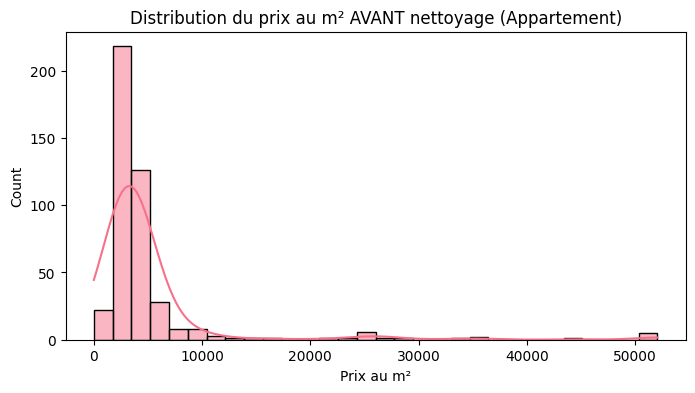

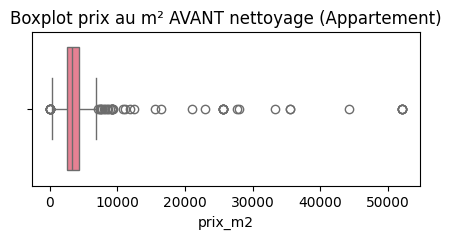

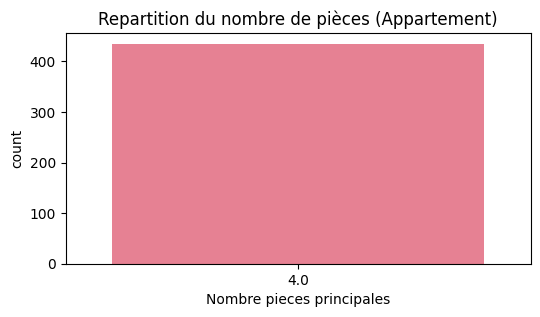

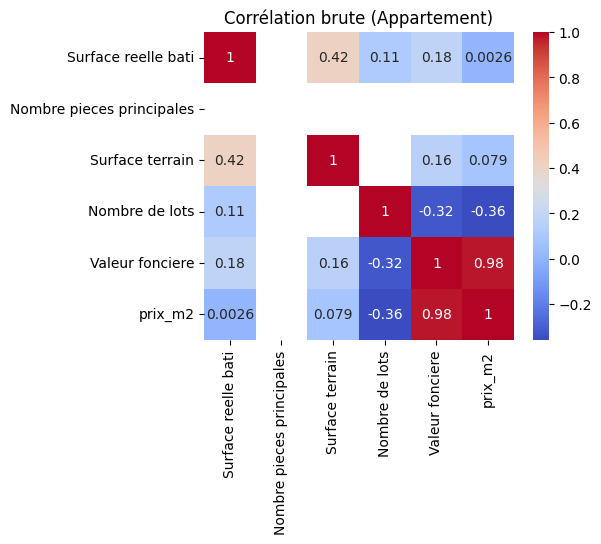

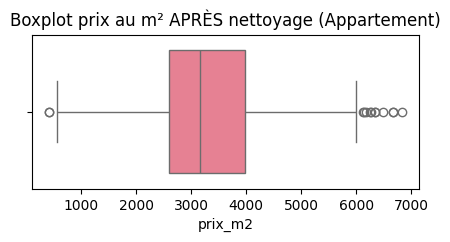

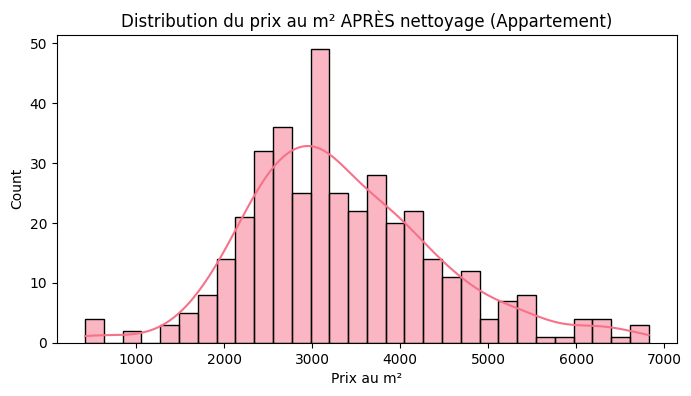

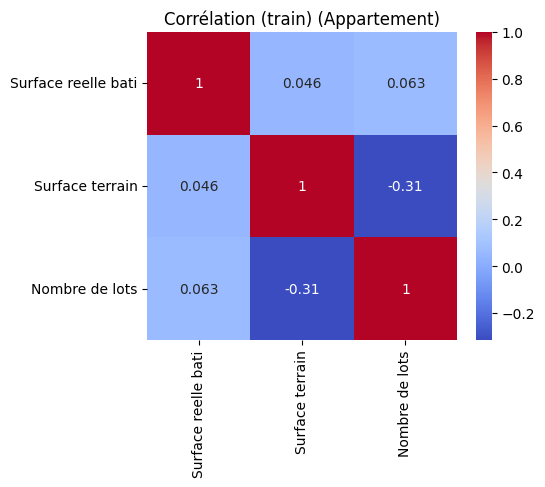

             Modèle       MSE        R2
0  LinearRegression  1.277973 -0.114024
1      DecisionTree  1.609726 -0.403217
2      RandomForest  1.331069 -0.160309
3           XGBoost  1.335487 -0.164160
4  DecisionTree_Opt  1.270642 -0.107634
5  RandomForest_Opt  1.348685 -0.175665
Meilleurs paramètres DecisionTree : {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Meilleurs paramètres RandomForest : {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Modèle sauvegardé : DecisionTree_Opt


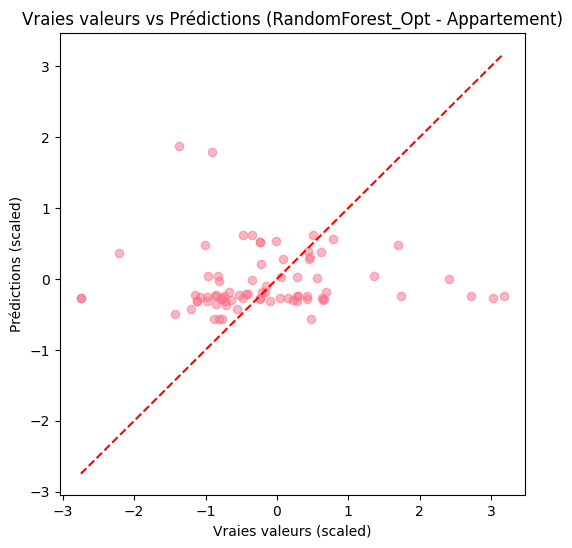

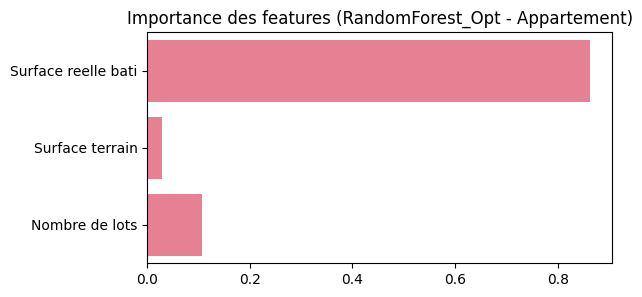

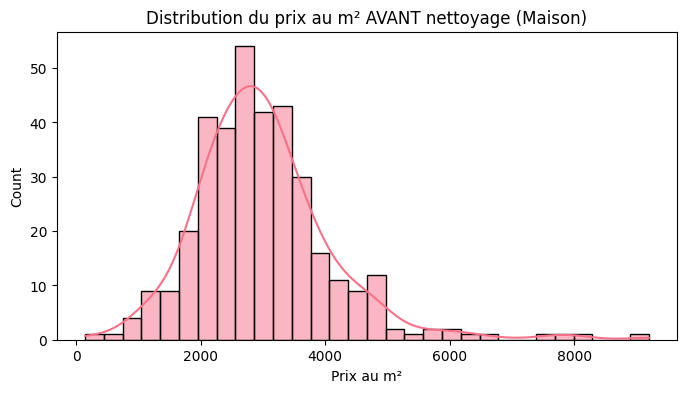

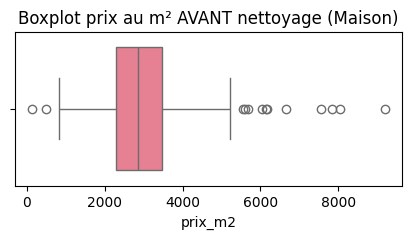

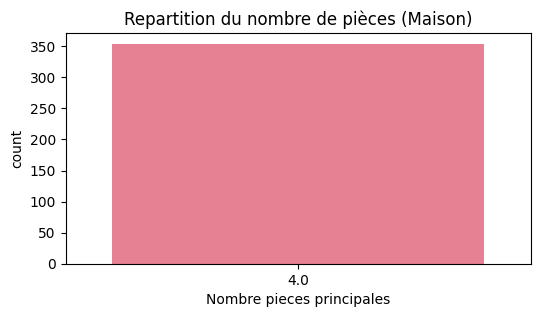

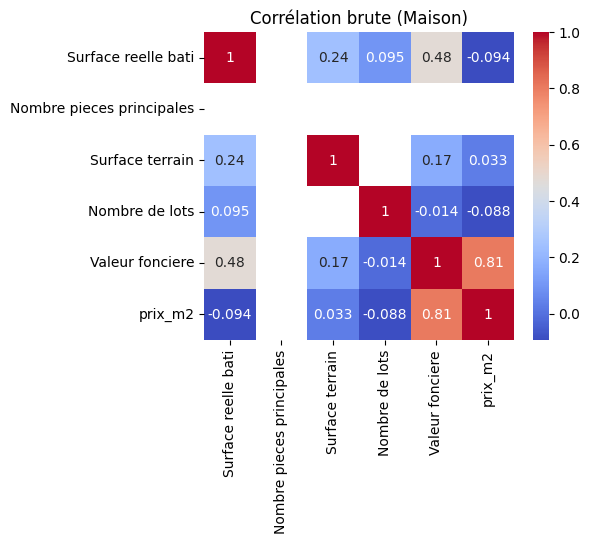

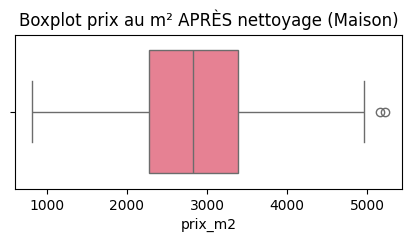

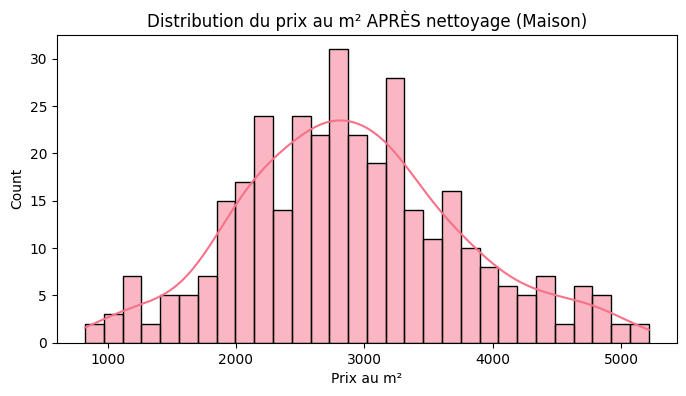

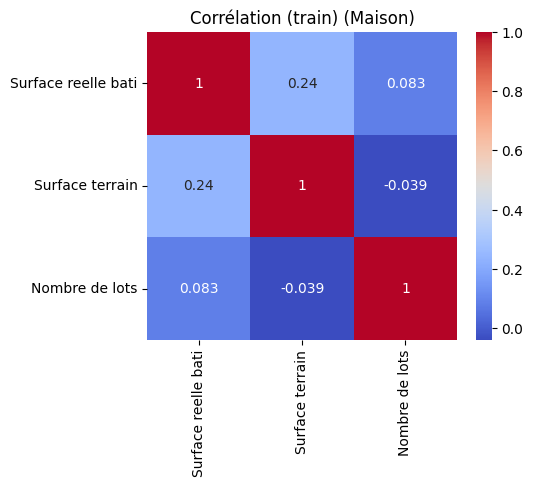

             Modèle       MSE        R2
0  LinearRegression  0.797919  0.032462
1      DecisionTree  1.848277 -1.241178
2      RandomForest  0.862550 -0.045908
3           XGBoost  0.810578  0.017112
4  DecisionTree_Opt  0.844032 -0.023454
5  RandomForest_Opt  0.763875  0.073743
Meilleurs paramètres DecisionTree : {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Meilleurs paramètres RandomForest : {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Modèle sauvegardé : RandomForest_Opt


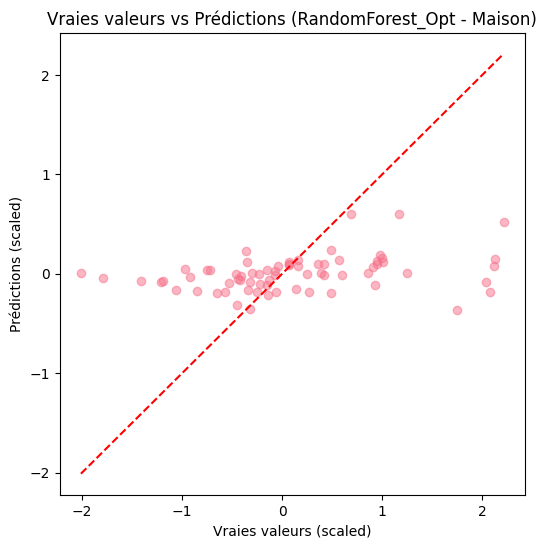

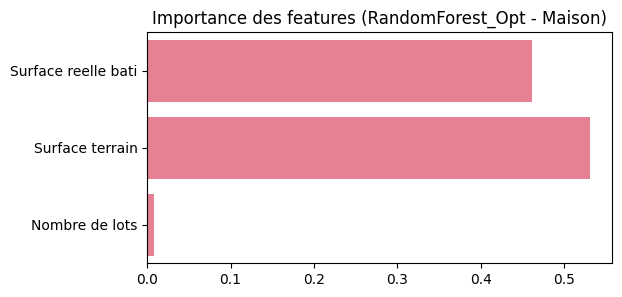

In [ ]:
# === Chargement et préparation des données ===
data: pd.DataFrame = pd.read_csv("../data/lille_2022.csv")  # Charge le fichier CSV des ventes immobilières
data_4p: pd.DataFrame = data[data["Nombre pieces principales"] == 4]  # Ne garde que les biens de 4 pièces

# === Pipeline pour les appartements ===
pipeline_appart: LillePricePipeline = LillePricePipeline(data_4p, "Appartement")  # Instancie le pipeline pour les appartements
pipeline_appart.train_models()  # Entraîne les modèles de base (régression, arbre, forêt, XGBoost)
pipeline_appart.grid_search()   # Optimise les hyperparamètres des arbres
pipeline_appart.evaluate_models()  # Évalue tous les modèles sur le test
print(pipeline_appart.summary_table())  # Affiche le tableau des scores
print("Meilleurs paramètres DecisionTree :", pipeline_appart.results['DecisionTree_Opt_params'])  # Affiche les meilleurs params DT
print("Meilleurs paramètres RandomForest :", pipeline_appart.results['RandomForest_Opt_params'])  # Affiche les meilleurs params RF
pipeline_appart.save_best("../models/model_appartements.pkl", "../models/scaler_x_appartements.pkl", "../models/scaler_y_appartements.pkl")  # Sauvegarde le meilleur modèle et les scalers
pipeline_appart.plot_predictions('RandomForest_Opt')  # Scatter plot vraies valeurs vs prédictions
pipeline_appart.plot_feature_importance('RandomForest_Opt')  # Barplot importance des features

# === Pipeline pour les maisons ===
pipeline_maison: LillePricePipeline = LillePricePipeline(data_4p, "Maison")  # Instancie le pipeline pour les maisons
pipeline_maison.train_models()  # Entraîne les modèles de base
pipeline_maison.grid_search()  # Optimise les hyperparamètres des arbres
pipeline_maison.evaluate_models()  # Évalue tous les modèles sur le test
print(pipeline_maison.summary_table())  # Affiche le tableau des scores
print("Meilleurs paramètres DecisionTree :", pipeline_maison.results['DecisionTree_Opt_params'])  # Affiche les meilleurs params DT
print("Meilleurs paramètres RandomForest :", pipeline_maison.results['RandomForest_Opt_params'])  # Affiche les meilleurs params RF
pipeline_maison.save_best("../models/model_maisons.pkl", "../models/scaler_x_maisons.pkl", "../models/scaler_y_maisons.pkl")  # Sauvegarde le meilleur modèle et les scalers
pipeline_maison.plot_predictions('RandomForest_Opt')  # Scatter plot vraies valeurs vs prédictions
pipeline_maison.plot_feature_importance('RandomForest_Opt')  # Barplot importance des features

## Visualisation comparative des performances

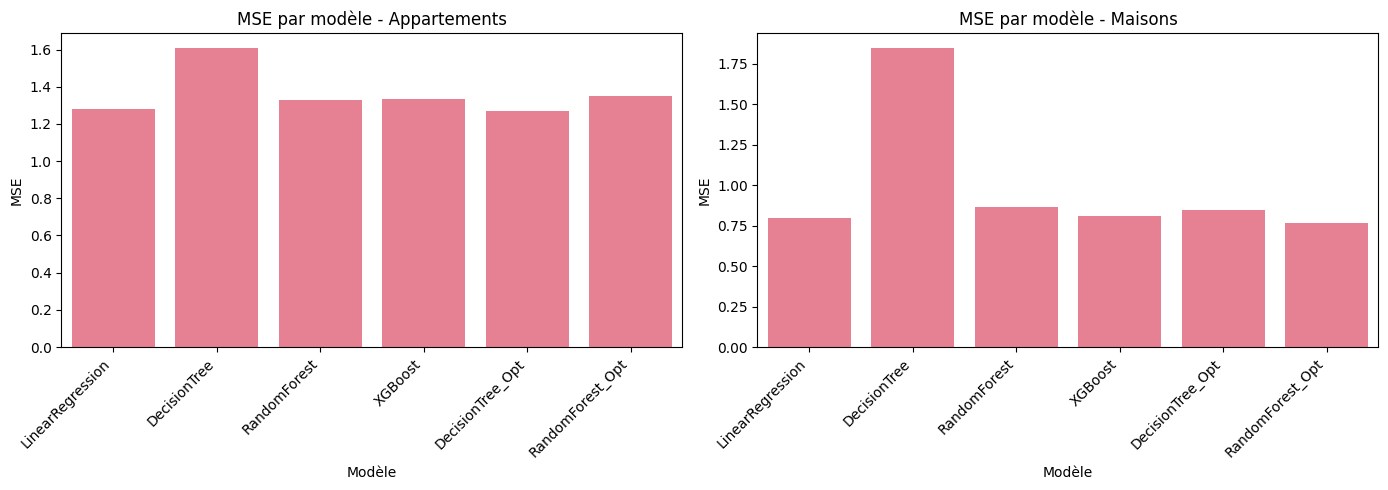

In [ ]:
# === Visualisation comparative des performances ===
df_appart: pd.DataFrame = pipeline_appart.summary_table()  # Récupère le tableau des scores pour les appartements
df_maison: pd.DataFrame = pipeline_maison.summary_table()  # Récupère le tableau des scores pour les maisons

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Crée une figure avec 2 sous-graphiques côte à côte

# Barplot des MSE pour chaque modèle sur les appartements
sns.barplot(x='Modèle', y='MSE', data=df_appart, ax=axes[0])  # Barplot MSE appartements
axes[0].set_title('MSE par modèle - Appartements')  # Titre du graphique
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')  # Rotation des labels X pour lisibilité

# Barplot des MSE pour chaque modèle sur les maisons
sns.barplot(x='Modèle', y='MSE', data=df_maison, ax=axes[1])  # Barplot MSE maisons
axes[1].set_title('MSE par modèle - Maisons')  # Titre du graphique
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')  # Rotation des labels X pour lisibilité

plt.tight_layout()  # Ajuste l'espacement pour éviter le chevauchement
plt.show()  # Affiche la figure